# Load Data

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init()

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql.functions import rand 
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StopWordsRemover

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link_animal_comments = "https://drive.google.com/file/d/1kO6xD-KOx19ikyFW_ILDDpXL60p7dwF-/view?usp=sharing"
id = '1kO6xD-KOx19ikyFW_ILDDpXL60p7dwF-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('animals_comments.csv')  
# rawData = pd.read_csv('animals_comments.csv')

In [5]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
df_raw = spark.read.load("/content/animals_comments.csv", format='csv', header = True, inferSchema = True)

In [6]:
# df_raw.show(10)

# Data Preprocessing && Exploratory Data Analysis

In [7]:
# check the data type of each column
df_raw.dtypes

[('creator_name', 'string'), ('userid', 'double'), ('comment', 'string')]

In [8]:
print("Number of rows in raw_df:", df_raw.count())

Number of rows in raw_df: 5820035


In [9]:
# Count null values in each columns 
print('Number of null values in creator_name: ',df_raw.filter(df_raw['creator_name'].isNull()).count())
print('Number of null values in userid: ',df_raw.filter(df_raw['userid'].isNull()).count())
print('Number of null values in comment: ',df_raw.filter(df_raw['comment'].isNull()).count())

Number of null values in creator_name:  32050
Number of null values in userid:  565
Number of null values in comment:  1051


In [10]:
#drop out rows with no comments and no userid
def pre_process(df):
  df_drop = df.filter(df['comment'].isNotNull() & df['userid'].isNotNull())
  df_drop = df_drop.dropDuplicates()

  print('After dropping, we have ', str(df_drop.count()), 'row in dataframe')
  return df_drop

df_clean = pre_process(df_raw)

After dropping, we have  5757212 row in dataframe


In [11]:
df_clean = df_clean.withColumn('comment', lower(col('comment')))
# df_clean.show(5)

In [12]:
# find user with preference of dog and cat
# note: please propose your own approach and rule to label data 
cond = (df_clean["comment"].like("%my dog%") | df_clean["comment"].like("%i have a dog%")\
        | df_clean["comment"].like("%my cat%") | df_clean["comment"].like("%i have a cat%") \
        | df_clean["comment"].like("%my dogs%") | df_clean["comment"].like("%my cats%")\
        | df_clean["comment"].like("%my cat%") | df_clean["comment"].like("%i have dogs%")\
        | df_clean["comment"].like("%i have cats%") | df_clean["comment"].like("%my puppy%")\
        | df_clean["comment"].like("%my kitten%") | df_clean["comment"].like("%i have a puppy%")\
        | df_clean["comment"].like("%i have puppies%"))

df_clean = df_clean.withColumn('dog_cat',  cond)

# find user do not have 
df_clean = df_clean.withColumn('no_pet', ~df_clean["comment"].like("%my%") & ~df_clean["comment"].like("%have%") & ~df_clean["comment"].like("%my dog%") \
                              & ~df_clean["comment"].like("%my cat%")) 


In [13]:
# df_clean.show(10)

In [14]:
# pyspark.ml.feature.RegexTokenizer(minTokenLength=1, gaps=True, pattern='\s+', inputCol=None, outputCol=None, toLowercase=True)
# RegexTokenizer基于正则表达式提供更多的划分选项
# "\\W" 是 word 
# minTokenLength = 1, 分出来的token 中的最低字母个数大于等于1

# . (dot): ANY ONE character except newline. Same as [^\n]
# \d, \D: ANY ONE digit/non-digit character. Digits are [0-9]
# \w, \W: ANY ONE word/non-word character. For ASCII, word characters are [a-zA-Z0-9_]
# \s, \S: ANY ONE space/non-space character. For ASCII, whitespace characters are [ \n\r\t\f]
# The \s (lowercase s) matches a whitespace (blank, tab \t, and newline \r or \n). On the other hand, the \S+ (uppercase S) matches anything that is NOT matched by \s, i.e., non-whitespace. In regex, the uppercase metacharacter denotes the inverse of the lowercase counterpart, for example, \w for word character and \W for non-word character; \d for digit and \D or non-digit.
# \w (word character) matches any single letter, number or underscore (same as [a-zA-Z0-9_]). The uppercase counterpart \W (non-word-character) matches any single character that doesn't match by \w (same as [^a-zA-Z0-9_]).
# https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html

regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="text", pattern="\\W")
df_clean = regexTokenizer.transform(df_clean)
# df_clean.show(10, False)

# Model Training

# only select 1000,000 rows for testing

In [15]:
# df_clean.head()
df_model = df_clean.select('*').limit(1000000)

In [16]:
df_model.show(1,False)

+------------+--------+-------------------------------------------------------------------------+-------+------+------------------------------------------------------------------------------------+
|creator_name|userid  |comment                                                                  |dog_cat|no_pet|text                                                                                |
+------------+--------+-------------------------------------------------------------------------+-------+------+------------------------------------------------------------------------------------+
|null        |124594.0|wtf como llegué aqui espero y alguien le sean útiles estos procedimientos|false  |true  |[wtf, como, llegu, aqui, espero, y, alguien, le, sean, tiles, estos, procedimientos]|
+------------+--------+-------------------------------------------------------------------------+-------+------+------------------------------------------------------------------------------------+
only showi

In [17]:
# df_clean.orderBy(rand(seed=0)).createOrReplaceTempView("table1")
# df_model = spark.sql("select * from table1 limit 1000000")

In [ ]:
word2Vec = Word2Vec(vectorSize = 50, minCount = 1, inputCol = "text", outputCol = "wordVector")
# model = word2Vec.fit(df_model)

# df_model = model.transform(df_model)
# df_model.show(10, False)

In [19]:
model = word2Vec.fit(df_model)

In [20]:
df_vec = model.transform(df_model)

In [21]:
df_vec.show(5, False)

+------------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
df_pets = df_vec.filter(col('dog_cat') == True) 
df_no_pets = df_vec.filter(col('no_pet') ==  True)
print("Number of confirmed user who own dogs or cats: ", df_pets.count())
print("Number of confirmed user who don't have pet's: ", df_no_pets.count())

Number of confirmed user who own dogs or cats:  9391
Number of confirmed user who don't have pet's:  832331


# consider to down sample the no pets data set

In [23]:
num_pos_label = df_pets.count()
# df_no_pets_down = df_no_pets.select("*").limit(2 * num_pos_label)
df_no_pets_down = df_no_pets.orderBy(rand()).select("*").limit(2 * num_pos_label)

In [24]:
df_no_pets_down.count()

18782

In [25]:
df_union = df_pets.select('dog_cat','wordVector').union(df_no_pets_down.select('dog_cat','wordVector'))

In [26]:
df_union.show(5, False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
df_union.filter(col("dog_cat") == False).count()

18782

In [28]:
udf_boolToInt= udf(lambda z: int(z * 1), IntegerType())
df_union = df_union.withColumn('label', udf_boolToInt('dog_cat'))

In [29]:
df_union.show(5, False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
train, test = df_union.randomSplit([0.8, 0.2], seed = 12345)

lr = LogisticRegression(featuresCol = "wordVector", labelCol = "label", maxIter = 10, regParam = 0.1)

# Run TrainValidationSplit, and choose the best set of parameters.
lrModel = lr.fit(train)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
predictions = lrModel.transform(test)

In [31]:
predictions.show(10, False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
trainingSummary = lrModel.summary
trainingSummary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|8.671291355389541E-4|0.028685790527018012|
|0.001867662753468...|0.054836557705136756|
|0.002601387406616...| 0.08245496997998666|
|0.003735325506937033| 0.10807204803202135|
|  0.0048025613660619| 0.13382254836557705|
|0.005269477054429029|  0.1609072715143429|
|0.005869797225186766|  0.1874583055370247|
|0.007137139807897...| 0.21280853902601735|
|0.008404482390608325|    0.23815877251501|
|0.009204909284951974| 0.26430953969312876|
|0.010205442902881537| 0.29006004002668445|
|0.011139274279615795|  0.3162108072048032|
|0.012273212379935965| 0.34169446297531686|
|0.013540554962646745|  0.3669112741827885|
|0.015141408751334046|  0.3914609739826551|
|0.016875667022411955|  0.4158772515010007|
|0.018209711846318036|  0.4410940627084723|
|0.019477054429028817| 0.46684456304202804|
|0.021211312700106722| 0.4912608

In [33]:
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

areaUnderROC: 0.9561948627437857


In [34]:
def get_evaluation_result(predictions):
  evaluator = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "rawPrediction", metricName = "areaUnderROC")
  AUC = evaluator.evaluate(predictions)

  TP = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 1.0)].count()
  FP = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 1.0)].count()
  TN = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 0.0)].count()
  FN = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 0.0)].count()

  accuracy = (TP + TN) * 1.0 / (TP + FP + TN + FN)
  precision = TP * 1.0 / (TP + FP)
  recall = TP * 1.0 / (TP + FN)

  print ("True Positives:", TP)
  print ("False Positives:", FP)
  print ("True Negatives:", TN)
  print ("False Negatives:", FN)
  print ("Test Accuracy:", accuracy)
  print ("Test Precision:", precision)
  print ("Test Recall:", recall)
  print ("Test AUC of ROC:", AUC)

print("Prediction result summary for Logistic Regression Model:  ")
get_evaluation_result(predictions)

Prediction result summary for Logistic Regression Model:  
True Positives: 1413
False Positives: 233
True Negatives: 3557
False Negatives: 483
Test Accuracy: 0.874076679563841
Test Precision: 0.8584447144592953
Test Recall: 0.745253164556962
Test AUC of ROC: 0.951500590049315


In [35]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol = "label", featuresCol = "wordVector", numTrees = 15)

# Train model.  This also runs the indexers.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)

In [36]:
# Select example rows to display.
predictions.show(10, False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
print("Prediction result summary for Random Forest Model:  ")
get_evaluation_result(predictions)

Prediction result summary for Random Forest Model:  
True Positives: 1398
False Positives: 146
True Negatives: 3644
False Negatives: 498
Test Accuracy: 0.8867393598311643
Test Precision: 0.905440414507772
Test Recall: 0.7373417721518988
Test AUC of ROC: 0.959367450430305


# Classify All Users

In [38]:
# get dataset for prediction (note to exclude people we already know the label)
# Users we don't know yet are those who don't own dog&cat and no_pets attribute is also flase
df_unknow = df_vec.filter((col('dog_cat') == False) & (col('no_pet') == False)) 
df_unknow = df_unknow.withColumn('label',df_unknow.dog_cat.cast('integer'))
print("There are {} users whose attribute is unclear.".format(df_unknow.count()))

There are 158278 users whose attribute is unclear.


In [39]:
pred_all = model.transform(df_unknow)
pred_all.show(10, False)

+----------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
#number of total user
total_user = df_vec.select('userid').distinct().count()
#number of labeled owner
owner_labeled = df_pets.select('userid').distinct().count() 
#number of owner predicted
owner_pred = pred_all.filter(col('prediction') == 1.0).count()

fraction = (owner_labeled + owner_pred) / total_user
print("Fraction of the users who are cat/dog owners (ML estimate):'%.3f' " % fraction)

Fraction of the users who are cat/dog owners (ML estimate):'0.065' 


# Get insights of users

In [41]:
df_all_owner = df_pets.select('text').union(pred_all.filter(col('prediction') == 1.0).select('text'))

stopwords_custom = ['im', 'get', 'got', 'one', 'hes', 'shes', 'dog', 'dogs', 'cats', 'cat', 'kitty', 'much', 'really', 'love','like','dont','know','want','thin',\
                    'see','also','never','go','ive']

remover1 = StopWordsRemover(inputCol = "raw", outputCol = "filtered")
core = remover1.getStopWords()
core = core + stopwords_custom
remover = StopWordsRemover(inputCol = "text", outputCol = "filtered",stopWords = core)
df_all_owner = remover.transform(df_all_owner)

wc = df_all_owner.select('filtered').rdd.flatMap(lambda a: a.filtered).countByValue()

In [42]:
df_all_owner.show(10, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [43]:
wcSorted = sorted(wc.items(), key=lambda kv: kv[1],reverse = True)
wcSorted

[('time', 4054),
 ('horse', 3529),
 ('people', 3497),
 ('old', 3439),
 ('little', 3350),
 ('good', 3345),
 ('think', 3342),
 ('even', 3255),
 ('back', 2905),
 ('day', 2861),
 ('video', 2836),
 ('well', 2743),
 ('still', 2737),
 ('years', 2683),
 ('life', 2645),
 ('always', 2581),
 ('2', 2566),
 ('mom', 2529),
 ('lol', 2510),
 ('make', 2326),
 ('3', 2308),
 ('way', 2252),
 ('take', 2184),
 ('said', 2162),
 ('going', 2147),
 ('home', 2136),
 ('first', 2126),
 ('cant', 2112),
 ('away', 2082),
 ('hope', 2060),
 ('thing', 2058),
 ('pet', 2016),
 ('animals', 2012),
 ('heart', 2006),
 ('two', 1993),
 ('house', 1978),
 ('ever', 1974),
 ('didnt', 1971),
 ('great', 1967),
 ('thats', 1965),
 ('help', 1964),
 ('put', 1961),
 ('videos', 1939),
 ('let', 1938),
 ('looks', 1921),
 ('around', 1909),
 ('doesnt', 1901),
 ('new', 1884),
 ('bad', 1877),
 ('year', 1871),
 ('name', 1871),
 ('died', 1852),
 ('right', 1849),
 ('need', 1846),
 ('say', 1844),
 ('baby', 1842),
 ('happy', 1804),
 ('family', 1762),

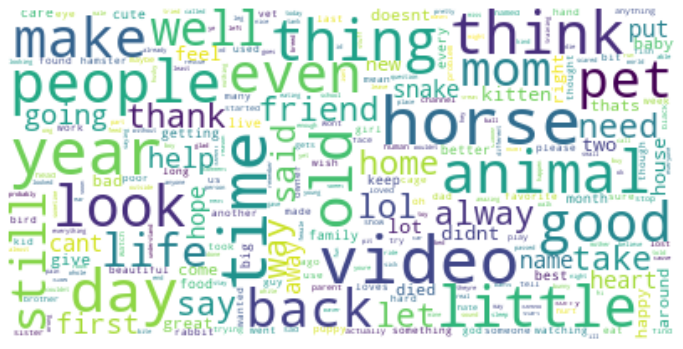

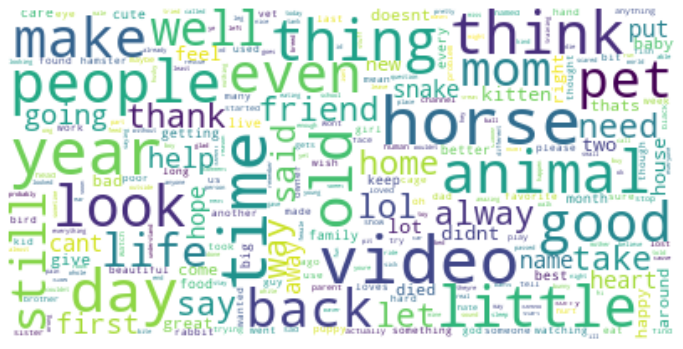

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join([(k + " ")*v for k,v in wc.items()])

wcloud = WordCloud(background_color="white", max_words=20000, collocations = False,
               contour_width=3, contour_color='steelblue',max_font_size=40)

# Generate a word cloud image
wcloud.generate(text)

# Display the generated image:
# the matplotlib way:
fig,ax0=plt.subplots(nrows=1,figsize=(12,8))
ax0.imshow(wcloud,interpolation='bilinear')

ax0.axis("off")
display(fig)

In [48]:
#Get all creators whenever the users label is True(cat/dog owner)
df_create = df_pets.select('creator_name').union(pred_all.filter(col('prediction') == 1.0).select('creator_name'))

# df_create.createOrReplaceTempView("create_table")

#get count
# create_count = spark.sql("select distinct creator_name, count(*) as Number\
#                           from create_table \
#                           group by creator_name \
#                           order by Number DESC")
create_count = df_create.groupBy("creator_name").count().orderBy("count", ascending = False)

In [49]:
create_count.show(10, False)

+---------------------------------------+-----+
|creator_name                           |count|
+---------------------------------------+-----+
|Brave Wilderness                       |3345 |
|The Dodo                               |3342 |
|Taylor Nicole Dean                     |2999 |
|Brian Barczyk                          |2723 |
|Hope For Paws - Official Rescue Channel|1384 |
|Cole & Marmalade                       |1251 |
|Gohan The Husky                        |1242 |
|Robin Seplut                           |1160 |
|Vet Ranch                              |1098 |
|Think Like A Horse                     |1090 |
+---------------------------------------+-----+
only showing top 10 rows

